# Sentiment Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from collections import Counter

In [2]:
tweets = pd.read_csv("tweets_all_hourly_processed.csv")
sentiments = pd.read_csv("sentiment_df_processed.csv")

tweets["tweet_created_at"] = pd.to_datetime(tweets["tweet_created_at"])
tweets["date"] = tweets["tweet_created_at"].dt.date

tweets = tweets.dropna().reset_index(drop=True)
sentiments = sentiments.dropna().reset_index(drop=True)

In [3]:
texts = pd.concat([sentiments["stemmed_text"], tweets["stemmed_tweet"]]).reset_index(drop=True)

## Bag-of-Words

In [4]:
count_vectorizer = CountVectorizer(max_features=3_000)
X = count_vectorizer.fit_transform(texts)
bow_df = pd.DataFrame(X.toarray(), columns=count_vectorizer.get_feature_names_out())

In [5]:
X_train = bow_df.iloc[:sentiments.shape[0]]
y_train = sentiments["sentiment"]
test = bow_df.iloc[sentiments.shape[0]:]

## ML Model (Multinomial Naive Bayes)

In [6]:
nb_classifier = MultinomialNB()

nb_classifier.fit(X_train, y_train)
pred = nb_classifier.predict(test)

In [7]:
tweets = pd.concat([tweets, pd.Series(pred, name="sentiment")], axis=1)

In [8]:
# Random Tweets with Sentiments
for i in range(10):
    num = np.random.choice(list(range(0, tweets.shape[0])))
    print(f"Original Tweet: {tweets.loc[num, 'tweet_text']}")
    print(f"Processed Tweet: {tweets.loc[num, 'stemmed_tweet']}")
    print(f"Sentiment: {tweets.loc[num, 'sentiment']}\n")

Original Tweet: Bu O. ÇOCUKLARINA NE ZAMAN MÜDAHELE EDECEKSİNİZ?

Aşağıdaki fiyatları görmüyor musunuz?Sadece 1 ürün.Neredeyse her şey de bunu yapıyorlar.

Gereğini,işinizi yapın,ya size güvenip o makama getiren Recep Tayyip Erdoğan'a daha fazla İHANET ETMEDEN BIRAKIN GİDİN!

@ticaret @mehmedmus https://t.co/6IeQJikePM
Processed Tweet: çocuk zaman müdahe aşağı fiyat görmüyor mus sade ürün nere iş yap güvenip maka getiren recep tayyip erdoğan fazl ihanet etme bırak git
Sentiment: Negative

Original Tweet: ⛔️244.Gün⛔️

 24.11.2021

24 Mart 2021’de
@UN 🇺🇳  @ilo tarafından verilen kararı uygulayın.

@ilo @iloankara @GuyRyder @ECHR_CEDH @tcbestepe @adalet_bakanlik @Akparti @herkesicinCHP @iyiparti @MHP_Bilgi @HDPgenelmerkezi @SaadetPartisi @devapartisi @GelecekPartiTR @AYMBASKANLIGI https://t.co/XIOh3Fdv1X
Processed Tweet: gün mart verilen karar uygulay
Sentiment: Positive

Original Tweet: @Filmzlecom1 @TahirSimsek Adamlar Selahattin Demirtaş a özgürlük sloganlar ı atıyorlar.neyin kafasını 

## Daily Sentiment Rates

In [9]:
daily_sentiment = pd.DataFrame(tweets.groupby(["date", "keyword"])["sentiment"].value_counts()).rename({"sentiment": "count"}, axis=1).reset_index()

In [10]:
keywords = ["akp", "akparti", "ak parti", "erdogan", "recep tayyip erdogan",
            "chp",  "kilicdaroglu", "kemal kilicdaroglu",
            "mhp",  "bahceli", "devlet bahceli",
            "hdp", "demirtas", "selahattin demirtas",
            "iyiparti", "iyi parti", "aksener", "meral aksener"]

akp_keywords = ["akp", "akparti", "ak parti", "erdogan", "recep tayyip erdogan"]
chp_keywords = ["chp", "kilicdaroglu", "kemal kilicdaroglu"]
mhp_keywords = ["mhp", "bahceli", "devlet bahceli"]
hdp_keywords = ["hdp", "demirtas", "selahattin demirtas"]
iyi_keywords = ["iyiparti", "iyi parti", "aksener", "meral aksener"]

keywords_lists = [akp_keywords, chp_keywords, mhp_keywords, hdp_keywords, iyi_keywords]
keywords_lists_str = ["AKP", "CHP", "MHP", "HDP", "İYİ"]

dates = sorted(tweets["date"].unique())

In [11]:
rates = []

for date in dates:
    for keyword in keywords:
        neg_count = daily_sentiment[(daily_sentiment["date"] == date) & (daily_sentiment["keyword"] == keyword) & (daily_sentiment["sentiment"] == "Negative")]["count"].values[0]
        pos_count = daily_sentiment[(daily_sentiment["date"] == date) & (daily_sentiment["keyword"] == keyword) & (daily_sentiment["sentiment"] == "Positive")]["count"].values[0]
        rates.append(pos_count / (pos_count + neg_count))

In [12]:
daily_sentiment_rates = pd.concat([daily_sentiment.drop_duplicates(["date", "keyword"]).reset_index(drop=True)[["date", "keyword"]], pd.Series(rates, name="pos_sent_rate")], axis=1)
daily_sentiment_rates["date_str"] = daily_sentiment_rates["date"].astype(str).apply(lambda x: x[5:])

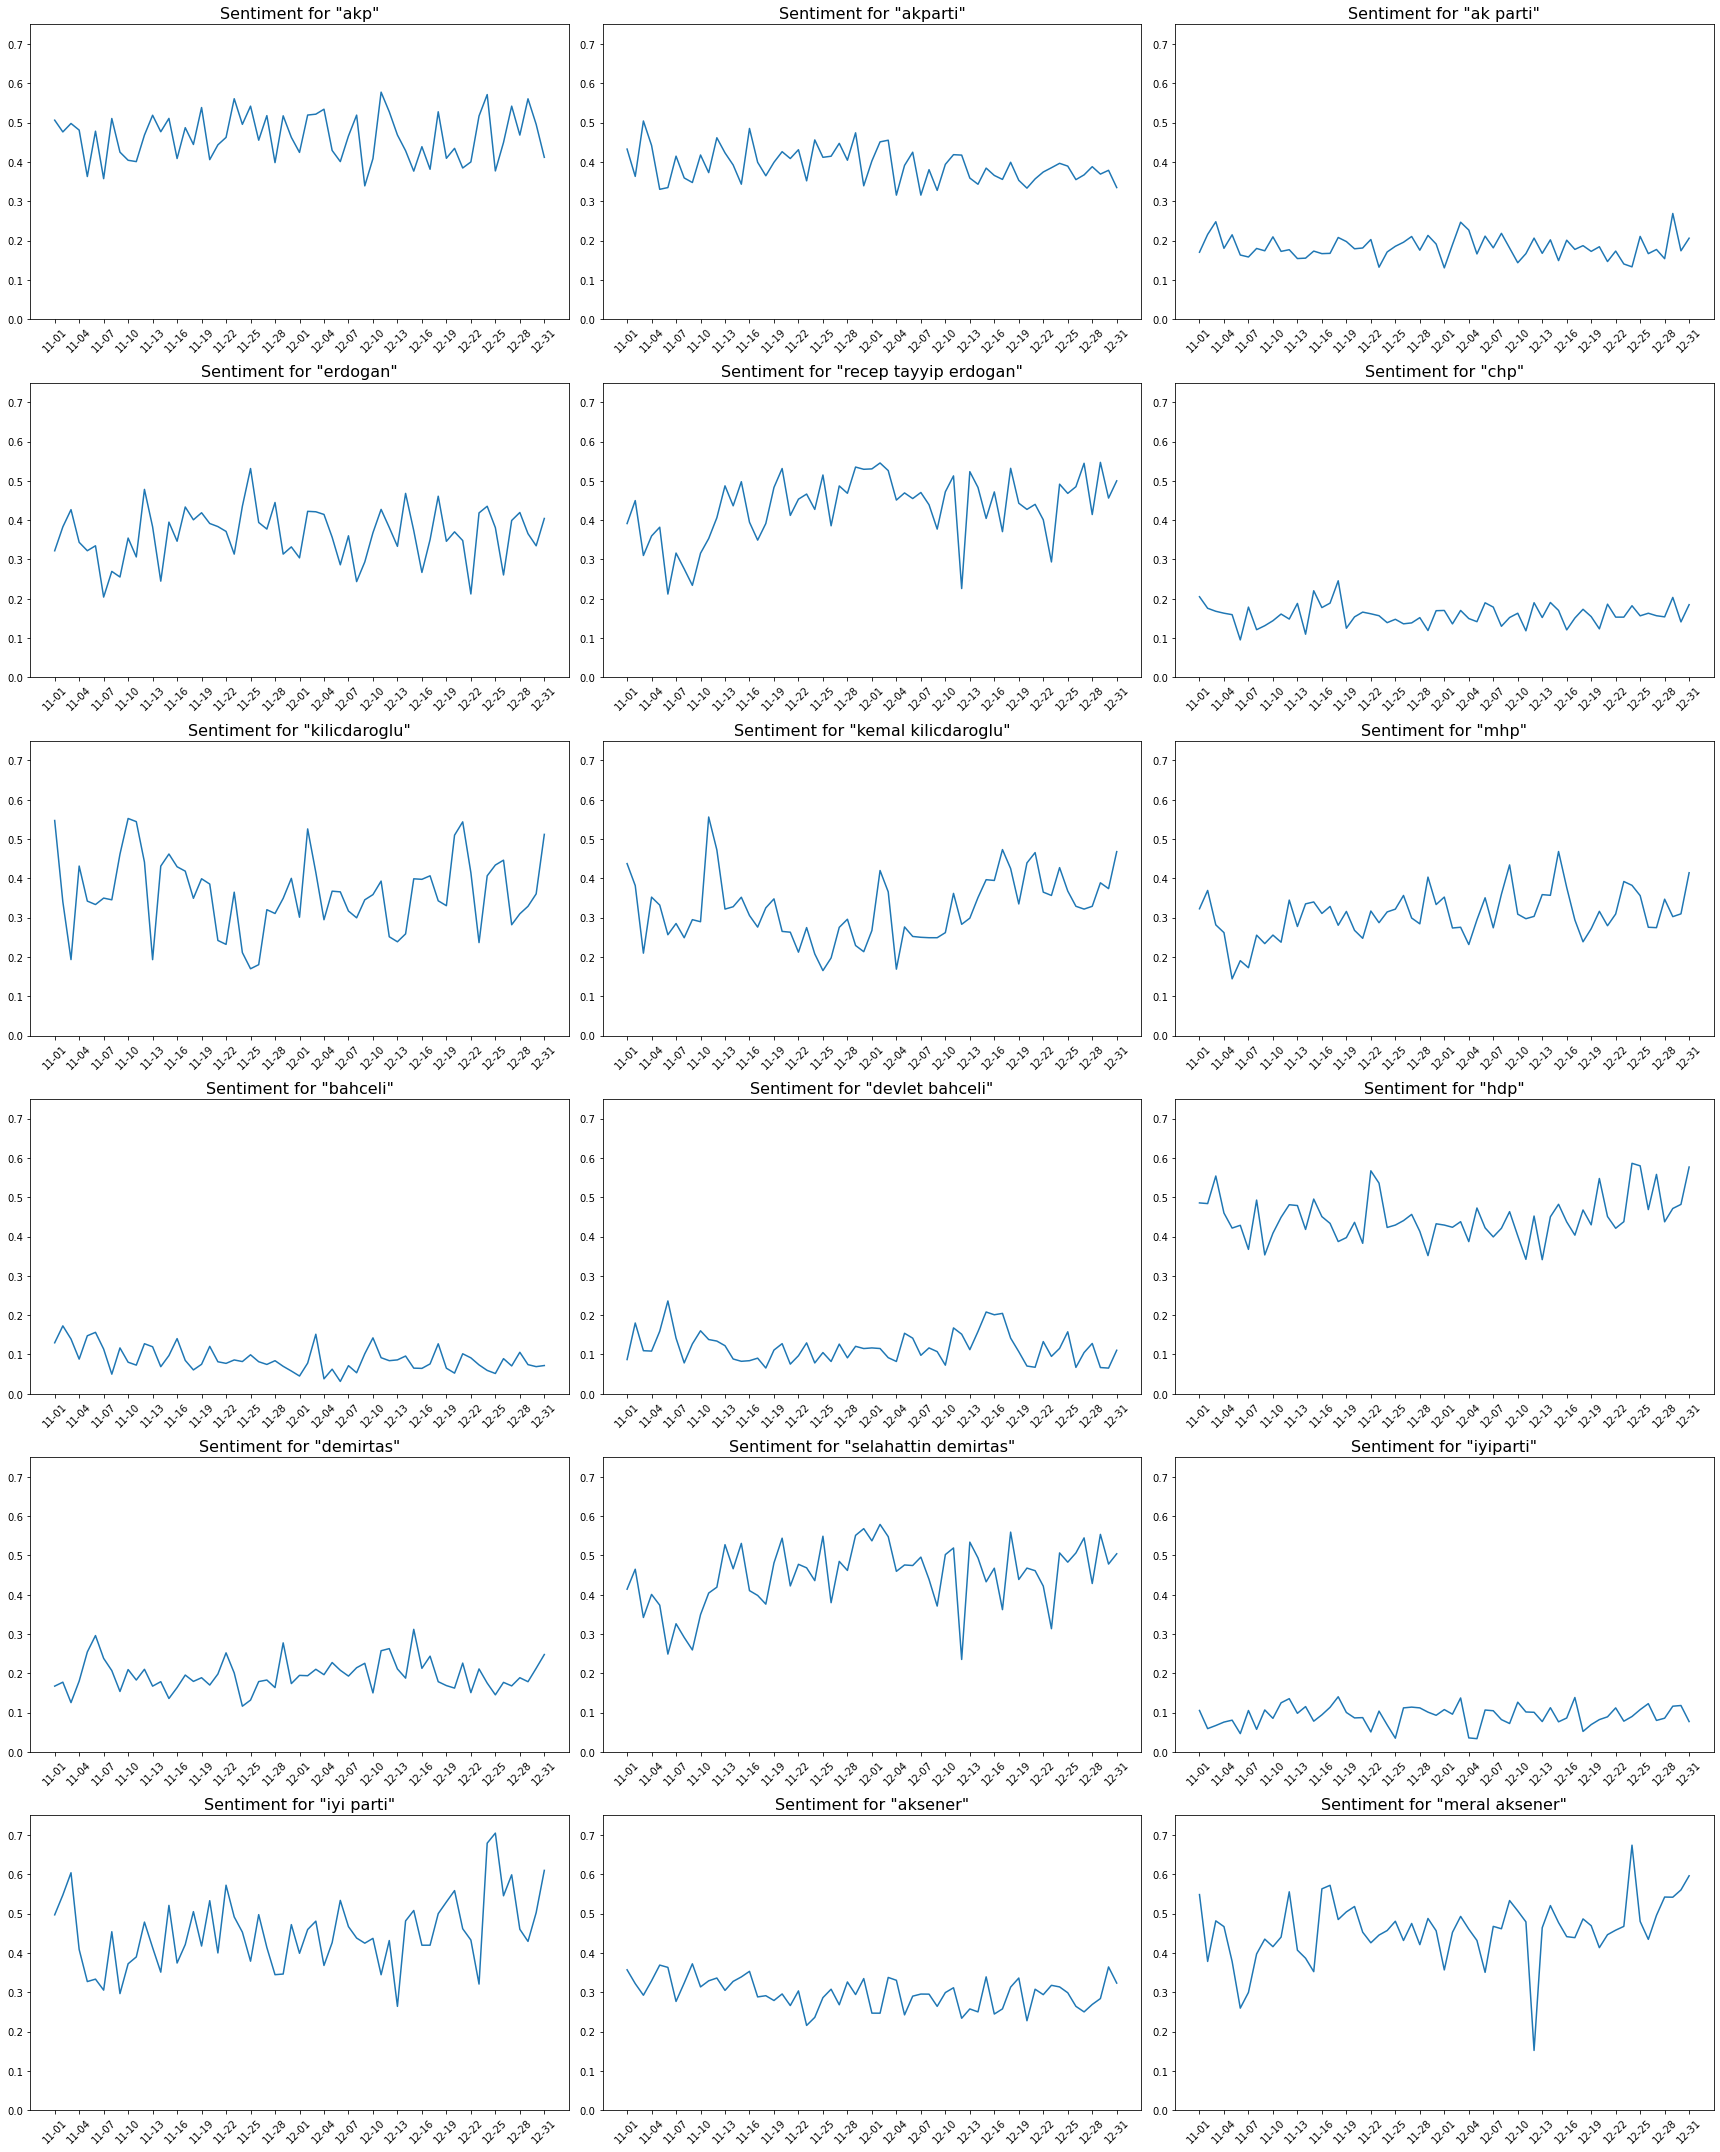

In [13]:
plt.figure(figsize=(24, 30))


for i in range(18):
    plt.subplot(6, 3, i+1)
    df = daily_sentiment_rates[daily_sentiment_rates["keyword"] == keywords[i]].reset_index(drop=True)
    
    plt.plot(df["date_str"], df["pos_sent_rate"])
    plt.title(f'Sentiment for "{keywords[i]}"', fontsize=16)
    plt.xticks(df["date_str"][::3], rotation=45)
    plt.ylim([0.0, 0.75])
    

plt.tight_layout()
plt.show()

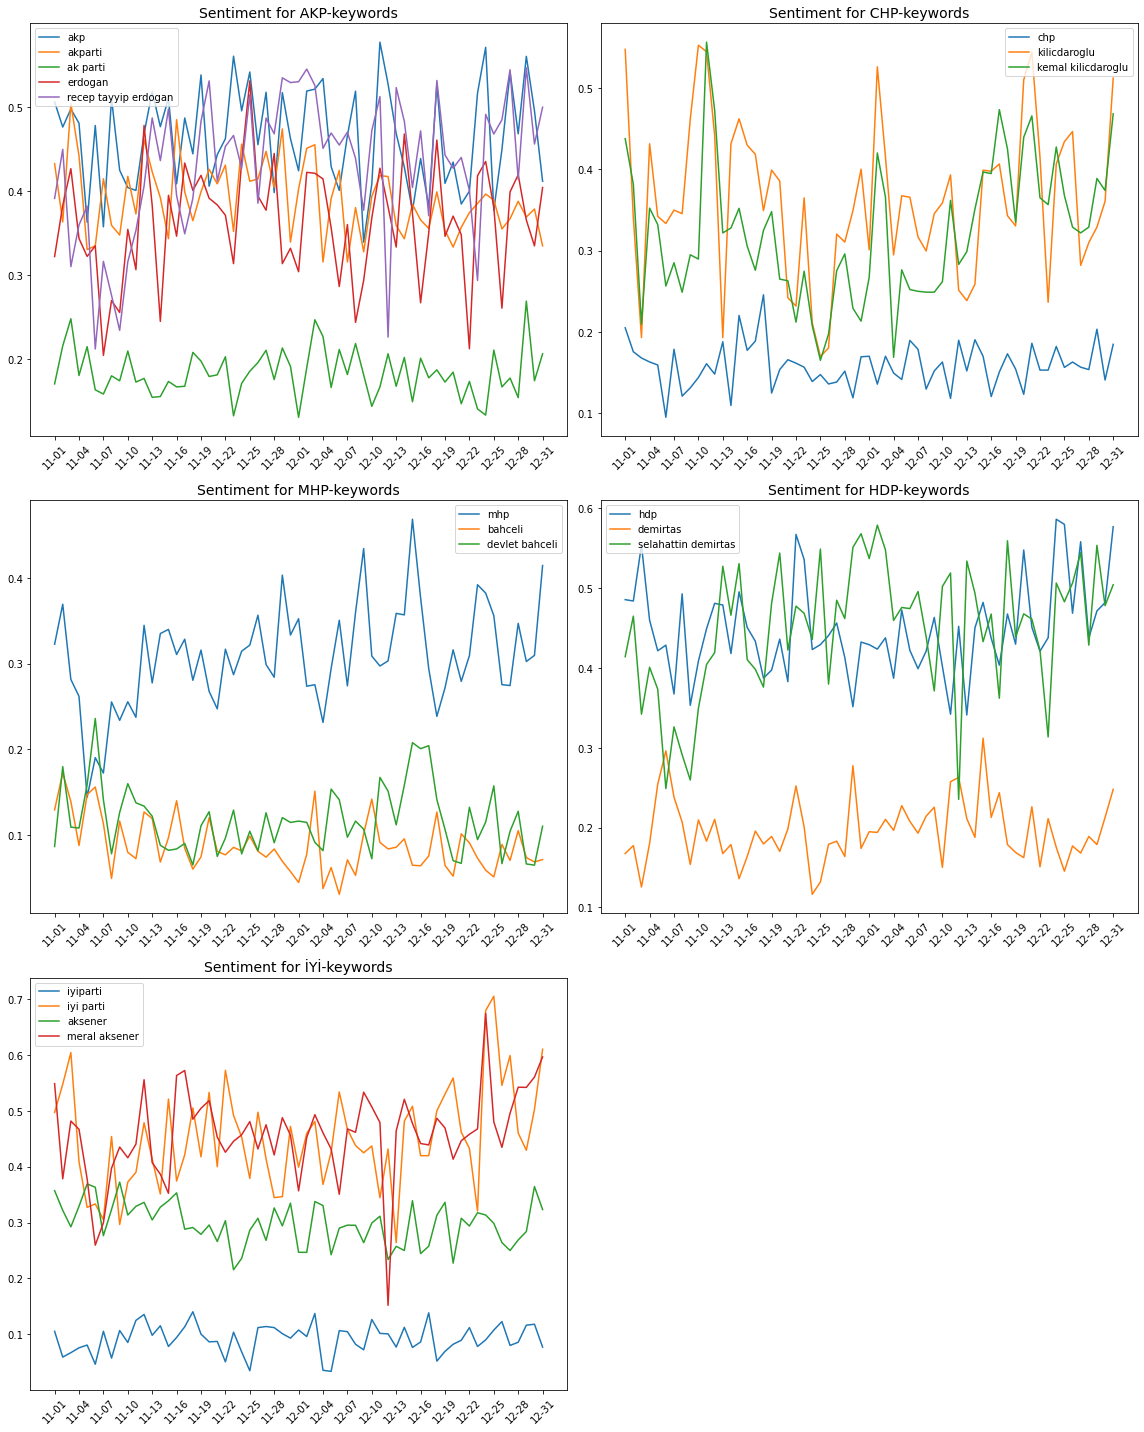

In [14]:
plt.figure(figsize=(16, 20))

for i, keywords_list in enumerate(keywords_lists):    
    plt.subplot(3, 2, i+1)
    for keyword in keywords_list:
        df = daily_sentiment_rates[daily_sentiment_rates["keyword"] == keyword].reset_index(drop=True)
        plt.plot(df["date_str"], df["pos_sent_rate"], label=keyword)
        plt.title(f"Sentiment for {keywords_lists_str[i]}-keywords", fontsize=14)

    plt.xticks(df["date_str"][::3], rotation=45)
    plt.legend()
    
plt.tight_layout()
plt.show()

## Word Counts

### Overall Word Counts

In [15]:
words = []

for tweet in tweets["stemmed_tweet"]:
    for word in tweet.split():
        words.append(word)

In [16]:
word_counts = pd.DataFrame(Counter(words).most_common(100)).rename({0: "word", 1: "count"}, axis=1)

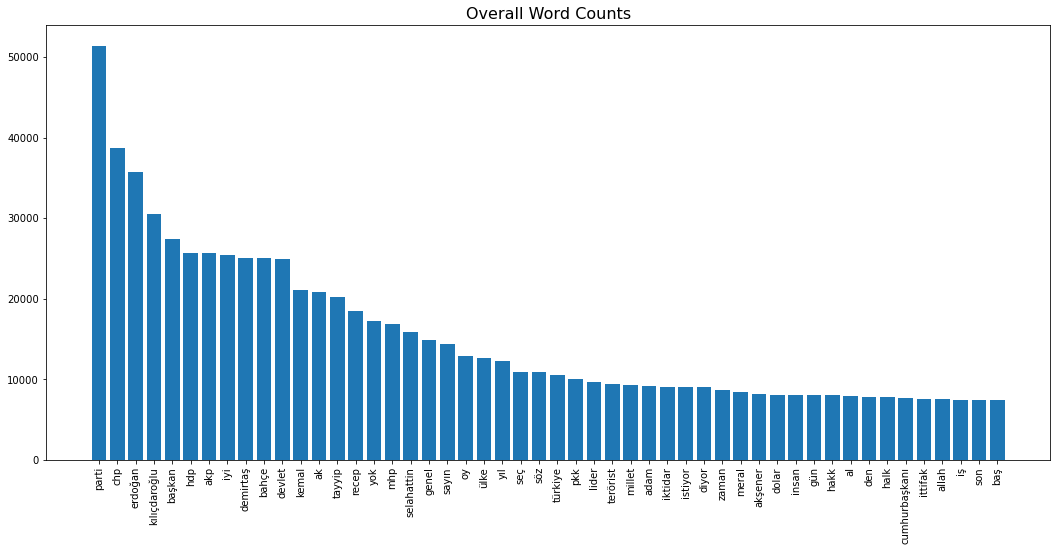

In [17]:
plt.figure(figsize=(18, 8))

plt.bar(word_counts["word"][:50], word_counts["count"][:50])
plt.xticks(rotation=90)
plt.title("Overall Word Counts", fontsize=16)
plt.show()

### Negative Word Counts

In [18]:
neg_words = []

for tweet in tweets[tweets["sentiment"] == "Negative"]["stemmed_tweet"]:
    for word in tweet.split():
        neg_words.append(word)

In [19]:
neg_word_counts = pd.DataFrame(Counter(neg_words).most_common(100)).rename({0: "word", 1: "count"}, axis=1)

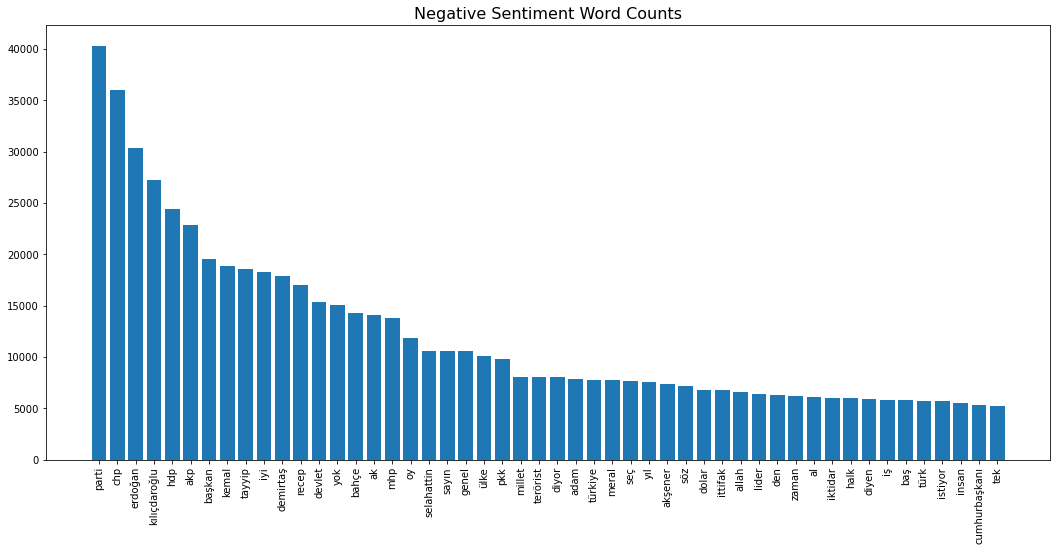

In [20]:
plt.figure(figsize=(18, 8))

plt.bar(neg_word_counts["word"][:50], neg_word_counts["count"][:50])
plt.xticks(rotation=90)
plt.title("Negative Sentiment Word Counts", fontsize=16)
plt.show()

### Positive Word Counts

In [21]:
pos_words = []

for tweet in tweets[tweets["sentiment"] == "Positive"]["stemmed_tweet"]:
    for word in tweet.split():
        pos_words.append(word)

In [22]:
pos_word_counts = pd.DataFrame(Counter(pos_words).most_common(100)).rename({0: "word", 1: "count"}, axis=1)

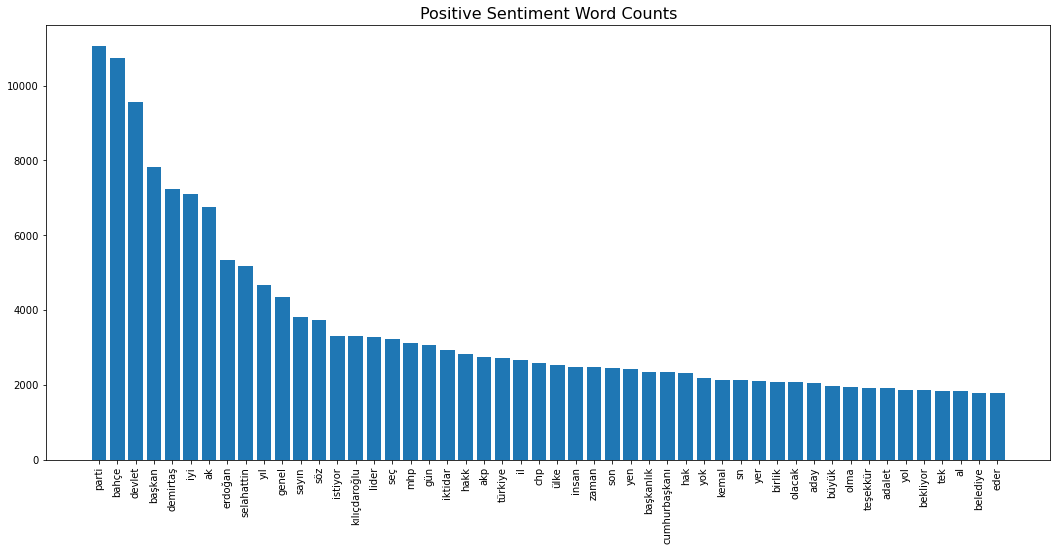

In [23]:
plt.figure(figsize=(18, 8))

plt.bar(pos_word_counts["word"][:50], pos_word_counts["count"][:50])
plt.xticks(rotation=90)
plt.title("Positive Sentiment Word Counts", fontsize=16)
plt.show()

In [24]:
pd.concat([neg_word_counts.rename({"word":"negative"}, axis=1)["negative"][:60],
           pos_word_counts.rename({"word":"positive"}, axis=1)["positive"][:60]], axis=1)

,negative,positive
0,parti,parti
1,chp,bahçe
2,erdoğan,devlet
3,kılıçdaroğlu,başkan
4,hdp,demirtaş
5,akp,iyi
6,başkan,ak
7,kemal,erdoğan
8,tayyip,selahattin
9,iyi,yıl


## Tweet Counts by Sentiment

In [25]:
keyword_sent_counts = pd.DataFrame(tweets.groupby("keyword")["sentiment"].value_counts()).rename({"sentiment":"count"}, axis=1).reset_index()

In [26]:
neg_tweet_counts = keyword_sent_counts[keyword_sent_counts["sentiment"] == "Negative"].sort_values("count", ascending=False).reset_index(drop=True)
pos_tweet_counts = keyword_sent_counts[keyword_sent_counts["sentiment"] == "Positive"].sort_values("count", ascending=False).reset_index(drop=True)

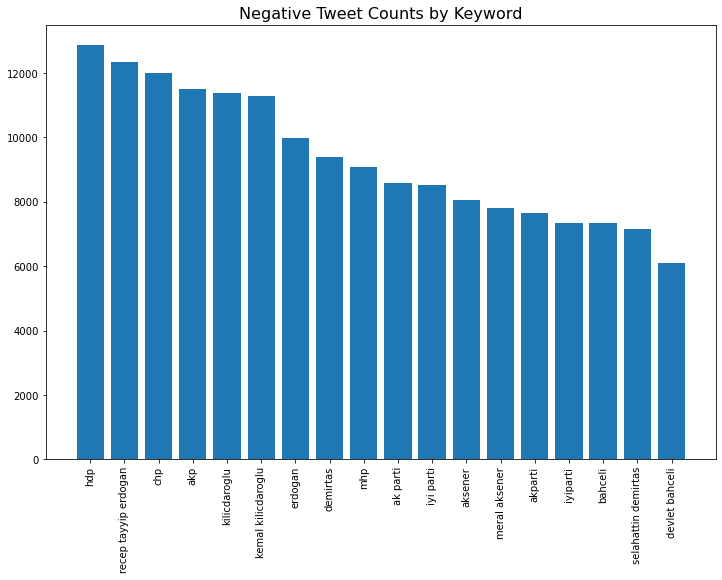

In [27]:
plt.figure(figsize=(12, 8))
plt.bar(neg_tweet_counts["keyword"], neg_tweet_counts["count"])
plt.title("Negative Tweet Counts by Keyword", fontsize=16)
plt.xticks(rotation=90)
plt.show()

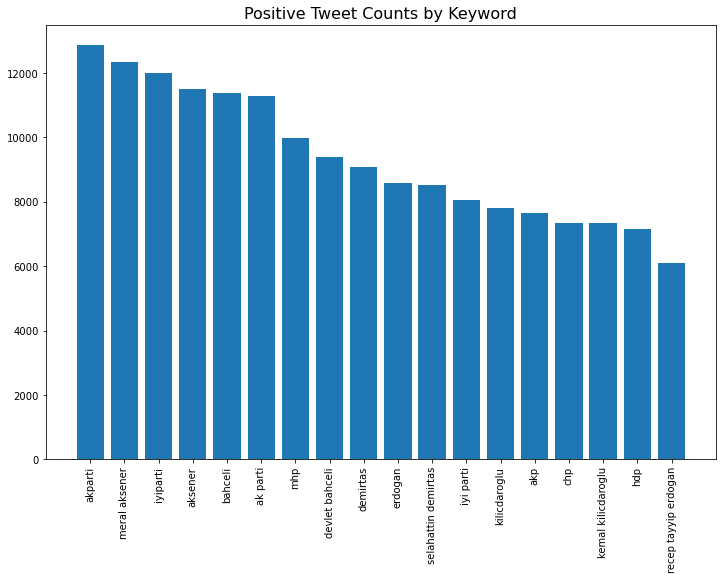

In [28]:
plt.figure(figsize=(12, 8))
plt.bar(pos_tweet_counts["keyword"], neg_tweet_counts["count"])
plt.title("Positive Tweet Counts by Keyword", fontsize=16)
plt.xticks(rotation=90)
plt.show()